In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras 
from tqdm import tqdm
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix , accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import glob 
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "./Fungi/",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 9114 files belonging to 5 classes.


In [5]:
class_names = dataset.class_names
class_names

['H1', 'H2', 'H3', 'H5', 'H6']

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[0 0 2 4 0 1 0 1 1 0 1 0 0 3 4 2 1 2 0 1 3 2 0 1 3 0 0 4 2 1 0 2]


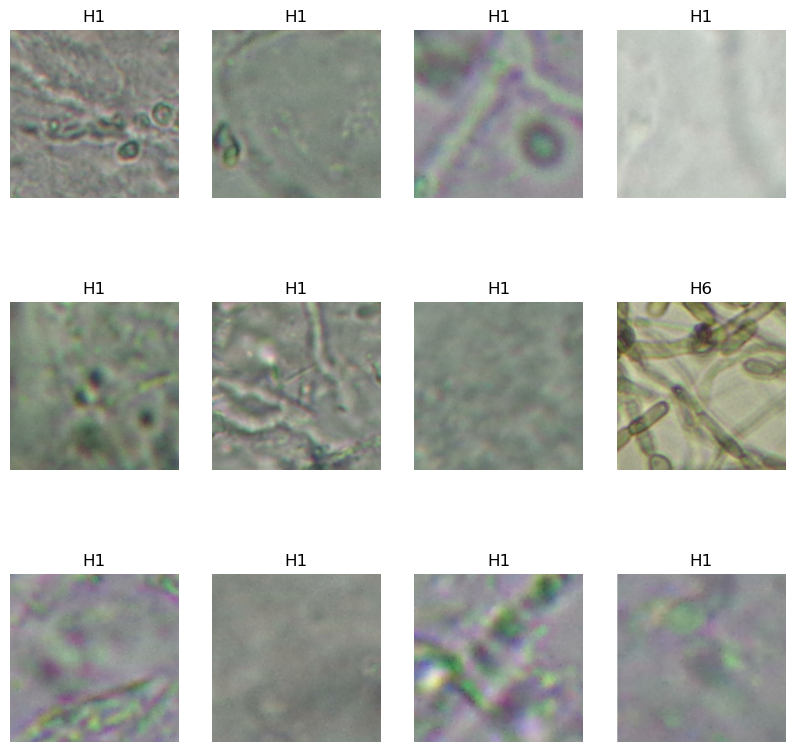

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
len(dataset)

285

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [11]:
print(len(train_ds),len(val_ds),len(test_ds))

228 28 29


In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255), 
])

In [14]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomContrast(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomFlip('horizontal')
])

In [15]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
train_ds = train_ds.map(
    lambda x, y: (tf.keras.applications.mobilenet_v3.preprocess_input(x), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
val_ds = val_ds.map(
    lambda x, y: (tf.keras.applications.mobilenet_v3.preprocess_input(x), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
base_model = tf.keras.applications.MobileNetV3Small(input_shape=(224,224,3),include_top=False,weights='imagenet')
base_model.trainable = False
keras_model=keras.models.Sequential()
keras_model.add(base_model)
keras_model.add(keras.layers.Flatten()) 
keras_model.add(keras.layers.Dropout(0.2))
keras_model.add(keras.layers.Dense(5,activation=tf.nn.softmax))
keras_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 28224)             0         
                                                                 
 dropout (Dropout)           (None, 28224)             0         
                                                                 
 dense (Dense)               (None, 5)                 141125    
                                                                 
Total params: 1,080,245
Trainable params: 141,125
Non-trainable params: 939,120
_________________________________________________________________


In [19]:
checkpoint =ModelCheckpoint("my_keras_model.h5", save_best_only=True,monitor='val_loss',verbose=1,mode='auto')
# Reduce learning rate on plateau
lr_plateau = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    verbose=0,
    min_delta=0.0001,
)

In [20]:
early_stopping =EarlyStopping(patience=5, restore_best_weights=True)

In [21]:
keras_model.compile(optimizer ='Adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:
hist=keras_model.fit_generator(train_ds,epochs=100,validation_data=val_ds,callbacks=[checkpoint,lr_plateau])

Epoch 1/100
228/228 [==============================] - ETA: 0s - loss: 1.3915 - accuracy: 0.6114
Epoch 1: val_loss improved from inf to 0.73706, saving model to my_keras_model.h5
228/228 [==============================] - 58s 192ms/step - loss: 1.3915 - accuracy: 0.6114 - val_loss: 0.7371 - val_accuracy: 0.7685 - lr: 0.0010
Epoch 2/100
228/228 [==============================] - ETA: 0s - loss: 0.9318 - accuracy: 0.7263
Epoch 2: val_loss improved from 0.73706 to 0.61904, saving model to my_keras_model.h5
228/228 [==============================] - 36s 160ms/step - loss: 0.9318 - accuracy: 0.7263 - val_loss: 0.6190 - val_accuracy: 0.8090 - lr: 0.0010
Epoch 3/100
228/228 [==============================] - ETA: 0s - loss: 0.7989 - accuracy: 0.7663
Epoch 3: val_loss improved from 0.61904 to 0.50721, saving model to my_keras_model.h5
228/228 [==============================] - 35s 155ms/step - loss: 0.7989 - accuracy: 0.7663 - val_loss: 0.5072 - val_accuracy: 0.8461 - lr: 0.0010
Epoch 4/100
22

228/228 [==============================] - 37s 163ms/step - loss: 0.2141 - accuracy: 0.9339 - val_loss: 0.3879 - val_accuracy: 0.9303 - lr: 1.0000e-04
Epoch 28/100
228/228 [==============================] - ETA: 0s - loss: 0.1936 - accuracy: 0.9357
Epoch 28: val_loss improved from 0.38790 to 0.37666, saving model to my_keras_model.h5
228/228 [==============================] - 37s 161ms/step - loss: 0.1936 - accuracy: 0.9357 - val_loss: 0.3767 - val_accuracy: 0.9382 - lr: 1.0000e-04
Epoch 29/100
228/228 [==============================] - ETA: 0s - loss: 0.1902 - accuracy: 0.9348
Epoch 29: val_loss did not improve from 0.37666
228/228 [==============================] - 37s 164ms/step - loss: 0.1902 - accuracy: 0.9348 - val_loss: 0.4011 - val_accuracy: 0.9247 - lr: 1.0000e-04
Epoch 30/100
228/228 [==============================] - ETA: 0s - loss: 0.1862 - accuracy: 0.9398
Epoch 30: val_loss improved from 0.37666 to 0.35563, saving model to my_keras_model.h5
228/228 [======================

228/228 [==============================] - ETA: 0s - loss: 0.1441 - accuracy: 0.9512
Epoch 54: val_loss did not improve from 0.34067
228/228 [==============================] - 36s 157ms/step - loss: 0.1441 - accuracy: 0.9512 - val_loss: 0.3425 - val_accuracy: 0.9416 - lr: 1.0000e-06
Epoch 55/100
228/228 [==============================] - ETA: 0s - loss: 0.1643 - accuracy: 0.9435
Epoch 55: val_loss did not improve from 0.34067
228/228 [==============================] - 35s 156ms/step - loss: 0.1643 - accuracy: 0.9435 - val_loss: 0.3426 - val_accuracy: 0.9416 - lr: 1.0000e-07
Epoch 56/100
228/228 [==============================] - ETA: 0s - loss: 0.1370 - accuracy: 0.9501
Epoch 56: val_loss did not improve from 0.34067
228/228 [==============================] - 35s 154ms/step - loss: 0.1370 - accuracy: 0.9501 - val_loss: 0.3426 - val_accuracy: 0.9416 - lr: 1.0000e-07
Epoch 57/100
228/228 [==============================] - ETA: 0s - loss: 0.1447 - accuracy: 0.9479
Epoch 57: val_loss did n

Epoch 82/100
228/228 [==============================] - ETA: 0s - loss: 0.1658 - accuracy: 0.9428
Epoch 82: val_loss did not improve from 0.34067
228/228 [==============================] - 37s 161ms/step - loss: 0.1658 - accuracy: 0.9428 - val_loss: 0.3426 - val_accuracy: 0.9416 - lr: 1.0000e-12
Epoch 83/100
228/228 [==============================] - ETA: 0s - loss: 0.1413 - accuracy: 0.9523
Epoch 83: val_loss did not improve from 0.34067
228/228 [==============================] - 36s 160ms/step - loss: 0.1413 - accuracy: 0.9523 - val_loss: 0.3426 - val_accuracy: 0.9416 - lr: 1.0000e-12
Epoch 84/100
228/228 [==============================] - ETA: 0s - loss: 0.1453 - accuracy: 0.9508
Epoch 84: val_loss did not improve from 0.34067
228/228 [==============================] - 38s 168ms/step - loss: 0.1453 - accuracy: 0.9508 - val_loss: 0.3426 - val_accuracy: 0.9416 - lr: 1.0000e-12
Epoch 85/100
228/228 [==============================] - ETA: 0s - loss: 0.1674 - accuracy: 0.9413
Epoch 85: v

In [32]:
test_ds = test_ds.map(
    lambda x, y: (tf.keras.applications.mobilenet_v3.preprocess_input(x), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [33]:
keras_model.evaluate(test_ds)

29/29 [==============================] - 1s 39ms/step - loss: 0.4350 - accuracy: 0.9289


[0.4350424110889435, 0.9288793206214905]

In [34]:
hist_=pd.DataFrame(hist.history)
hist_

,loss,accuracy,val_loss,val_accuracy,lr
0,1.391508,0.611385,0.737056,0.768539,1.000000e-03
1,0.931818,0.726337,0.619040,0.808989,1.000000e-03
2,0.798931,0.766255,0.507213,0.846067,1.000000e-03
3,0.719521,0.788066,0.563787,0.835955,1.000000e-03
4,0.651657,0.811660,0.488134,0.877528,1.000000e-03
...,...,...,...,...,...
95,0.142343,0.950206,0.342575,0.941573,1.000000e-15
96,0.151643,0.947325,0.342575,0.941573,1.000000e-15
97,0.153156,0.946639,0.342575,0.941573,1.000000e-15
98,0.150712,0.946365,0.342575,0.941573,1.000000e-15


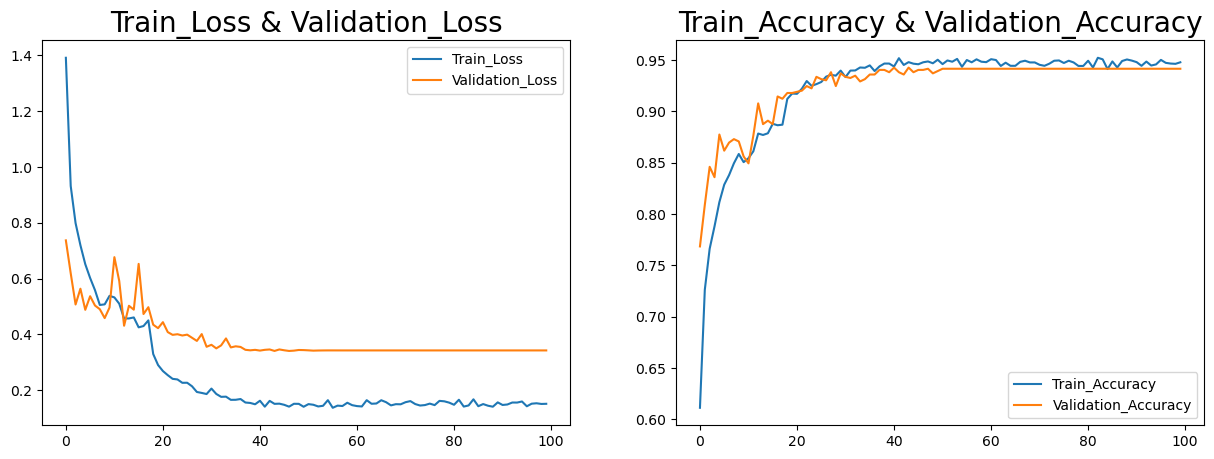

In [35]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

In [36]:
X_val,y_val,y_pred=[],[],[]
for images, labels in test_ds:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())
predictions=keras_model.predict(np.array(X_val))
for i in predictions:
    y_pred.append(np.argmax(i))
df=pd.DataFrame()
df['Actual'],df['Prediction']=y_val,y_pred
df

29/29 [==============================] - 1s 46ms/step


,Actual,Prediction
0,3,3
1,2,2
2,2,2
3,0,0
4,4,4
...,...,...
923,0,0
924,1,1
925,1,1
926,2,2


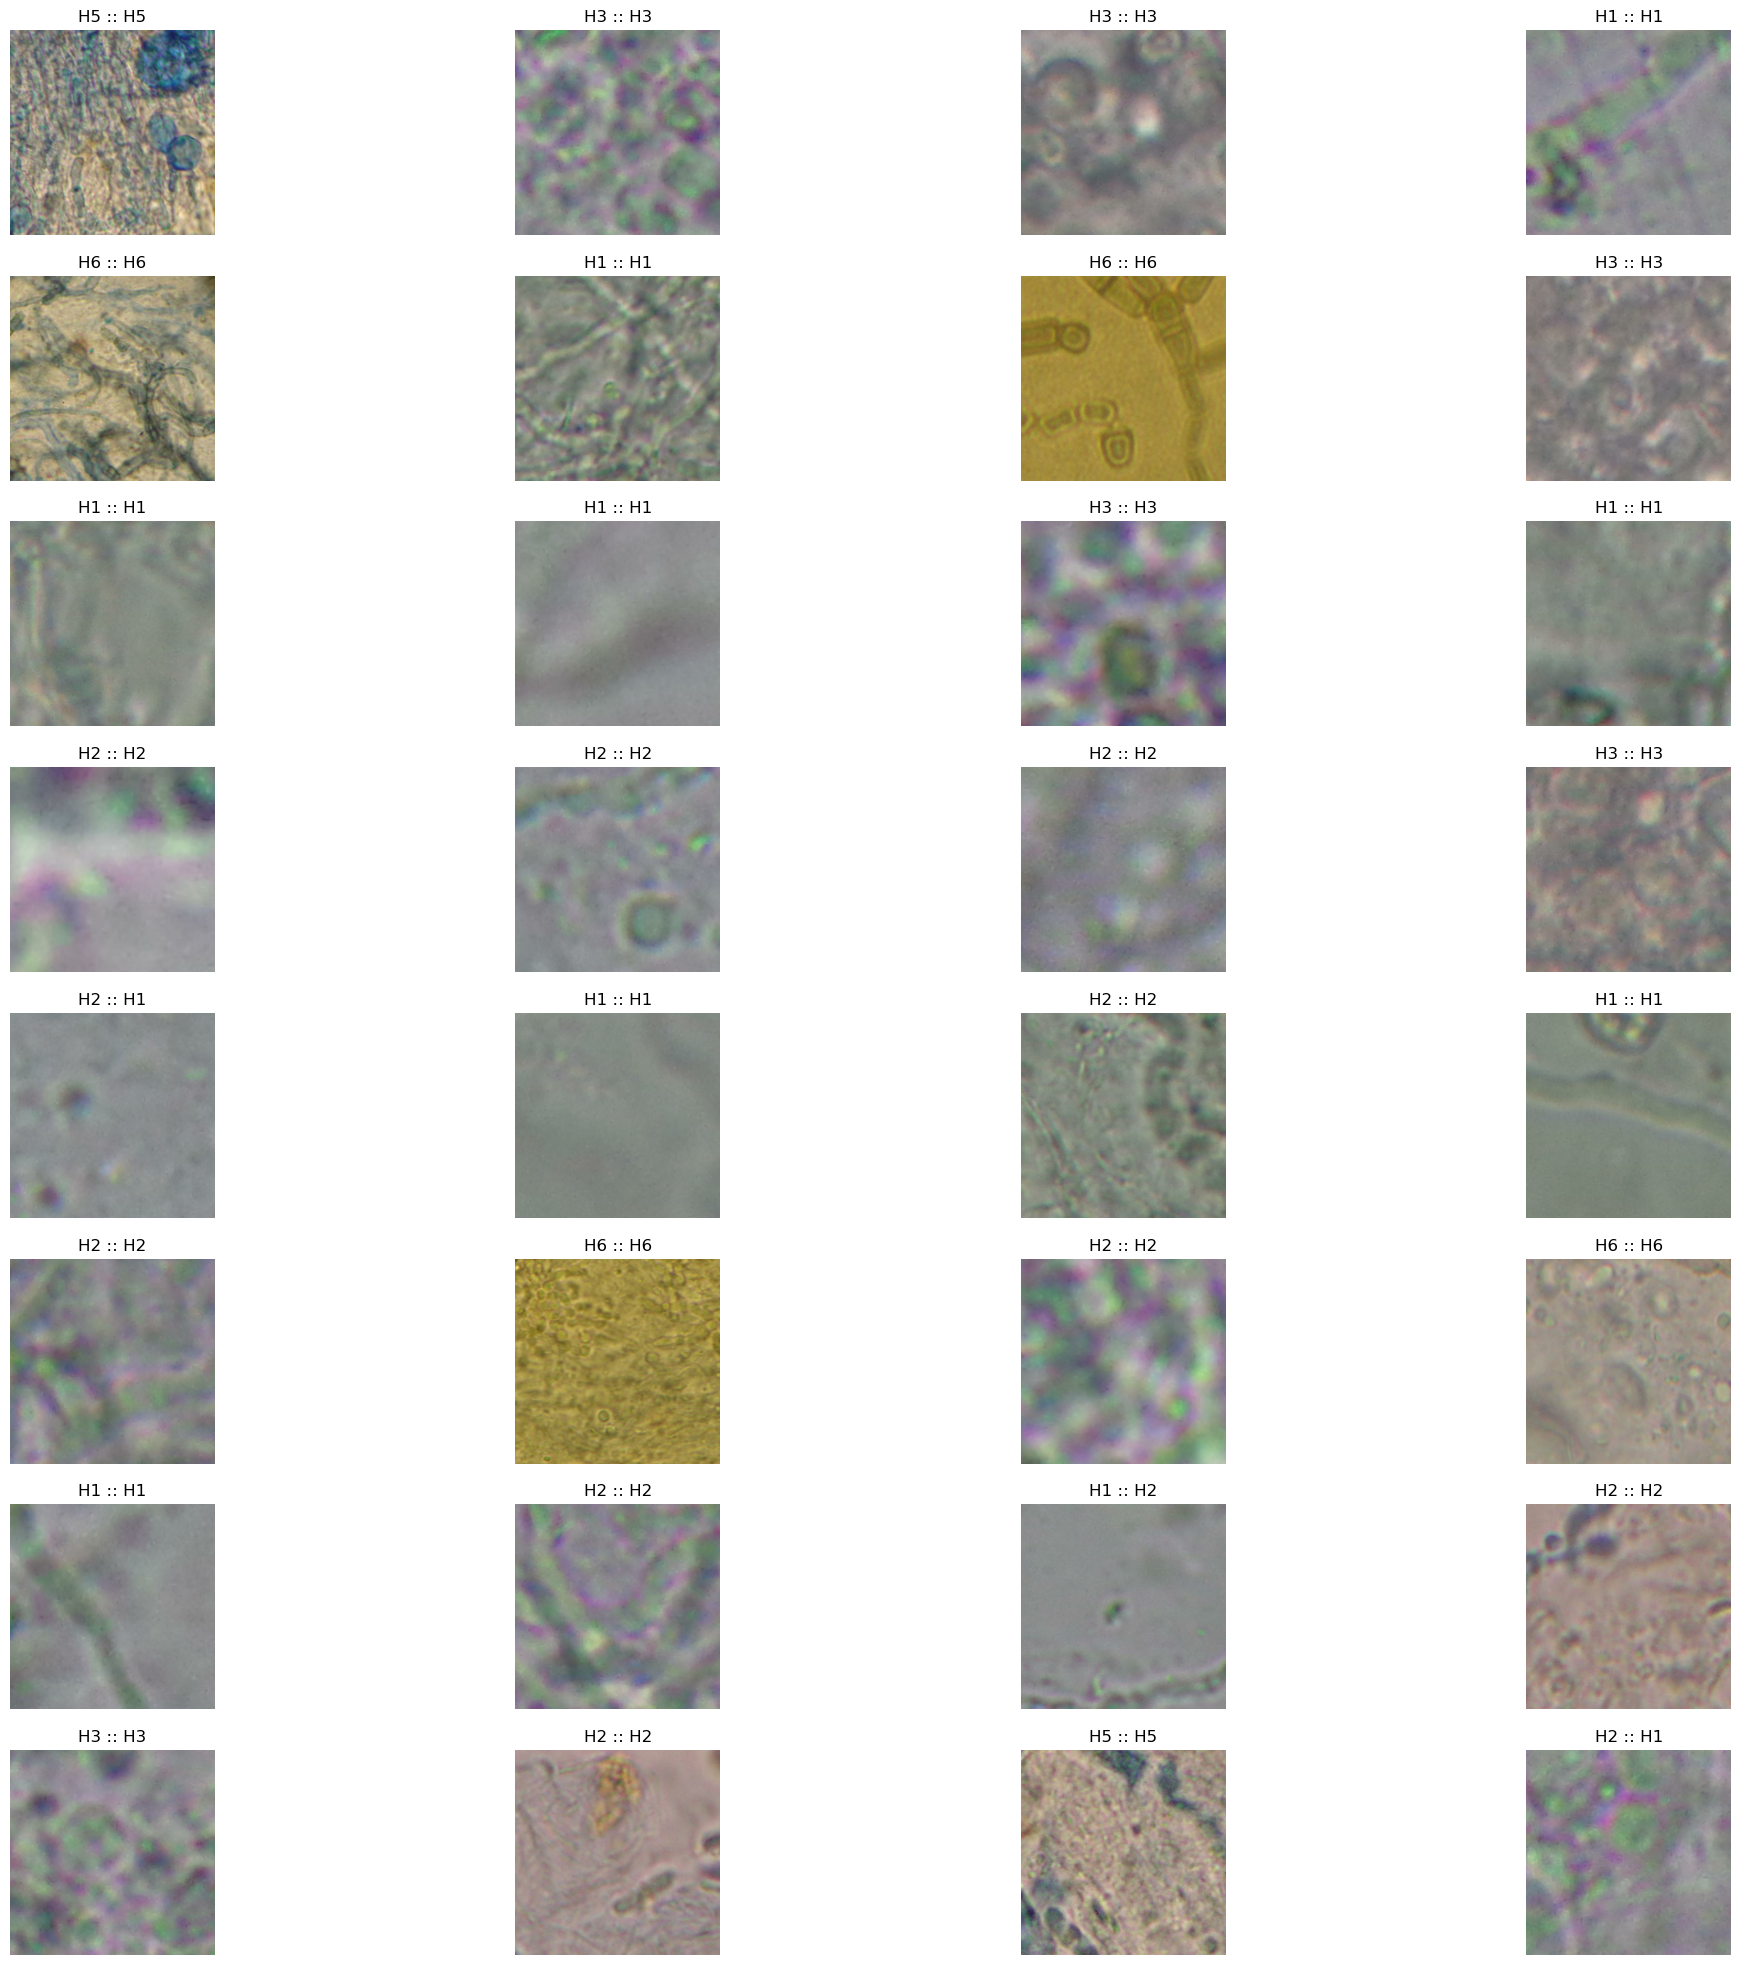

In [37]:
plt.figure(figsize=(25,25))
for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(X_val[i].astype("uint8"))
    plt.title(f'{class_names[y_val[i]]} :: {class_names[y_pred[i]]}')
    plt.axis("off")

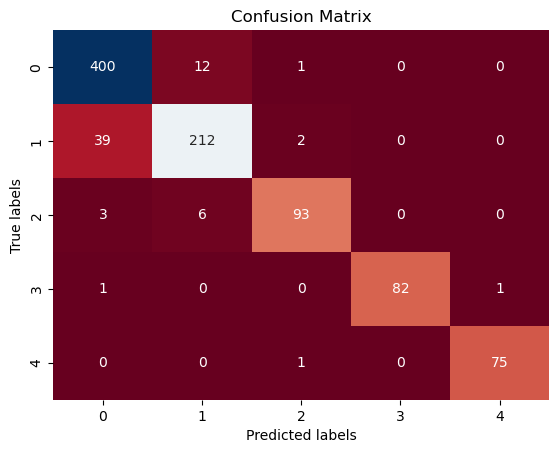

array([[400,  12,   1,   0,   0],
       [ 39, 212,   2,   0,   0],
       [  3,   6,  93,   0,   0],
       [  1,   0,   0,  82,   1],
       [  0,   0,   1,   0,  75]], dtype=int64)

In [38]:
ax= plt.subplot()
CM = confusion_matrix(y_val,y_pred)
sns.heatmap(CM, annot=True, fmt='g', ax=ax,cbar=False,cmap='RdBu')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
plt.show()
CM

In [39]:
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       413
           1       0.92      0.84      0.88       253
           2       0.96      0.91      0.93       102
           3       1.00      0.98      0.99        84
           4       0.99      0.99      0.99        76

    accuracy                           0.93       928
   macro avg       0.95      0.94      0.94       928
weighted avg       0.93      0.93      0.93       928

